In [47]:
#Loading the dataset
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'
#Userid-songid-listen__count
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'



In [48]:
#Importing the dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation


In [49]:
song_df1 = pd.read_table(triplets_file, header = None)
song_df1.columns = ['user_id', 'song_id', 'listen_count']

#reading song metadata
song_df2 = pd.read_csv(songs_metadata_file)

#Merging the two dataframes to create the input for our sys
song_df = pd.merge(song_df1, song_df2.drop_duplicates(['song_id']),
                   on = 'song_id', how = 'left')

In [50]:
#Exploring the data
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [51]:
len(song_df)

2000000

In [52]:
#Creating a subset to ensure faster training
song_df = song_df.head(10000)

#merge song title and artist name columns
song_df['song'] = song_df['title'].map(str) + "-" + song_df['artist_name']

In [53]:
#Showing the most popular songs in the dataset
song_grouped = song_df.groupby(['song']).agg({'listen_count' : 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage'] = song_grouped['listen_count'].div(grouped_sum) * 100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])


,song,listen_count,percentage
3660,Sehr kosmisch-Harmonia,45,0.45
4678,Undo-Björk,32,0.32
5105,You're The One-Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit)-Florence + The ...,28,0.28
3655,Secrets-OneRepublic,28,0.28
...,...,...,...
5139,high fives-Four Tet,1,0.01
5140,in white rooms-Booka Shade,1,0.01
5143,paranoid android-Christopher O'Riley,1,0.01
5149,¿Lo Ves? [Piano Y Voz]-Alejandro Sanz,1,0.01


In [54]:
#No of unique users and songs in the dataset
users = song_df['user_id'].unique()
songs = song_df['song'].unique()
print('Unique users', len(users))
print('Unique songs', len(songs))

Unique users 365
Unique songs 5151


In [55]:
#Building the song recommender
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id  ...                                 song
7389  94d5bdc37683950e90c56c9b32721edb5d347600  ...          Half Of My Heart-John Mayer
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  ...  The Beautiful People-Marilyn Manson
2995  15415fa2745b344bce958967c346f2a89f792f63  ...       Sanctify Yourself-Simple Minds
5316  ffadf9297a99945c0513cd87939d91d8b602936b  ...       Heart Cooks Brain-Modest Mouse
356   5a905f000fc1ff3df7ca807d57edb608863db05d  ...                Rorol-Octopus Project

[5 rows x 8 columns]


In [56]:
#Popularity based song recommender

pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

In [57]:
#Using pm to make predictions
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch-Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo-Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit)-Florence + The ...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One-Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry-Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets-OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody-Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies-Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister-Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


In [58]:
#Personalised song recommender
#Creating an instance of the personalized recommender class
is_model = Recommenders.item_similarity_recommender_py() #Item similarity model
is_model.create(train_data, 'user_id', 'song')

In [59]:
#Print the songs for the following user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)

print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It-Eminem
Without Me-Eminem
16 Candles-The Crests
Speechless-Lady GaGa
Push It-Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix)-Deadmau5
Say My Name-Destiny's Child
My Dad's Gone Crazy-Eminem / Hailie Jade
The Real Slim Shady-Eminem
Somebody To Love-Justin Bieber
Forgive Me-Leona Lewis
Missing You-John Waite
Ya Nada Queda-Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman-Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird-Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back-Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile-Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You-3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound-J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0)-The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version)-War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling-Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster)-The Mi...,0.052564,10


In [60]:
#Print the songs for the following user in training data. Note the difference in
#songs recommended for both users
user_id = users[17]
user_items = is_model.get_user_items(user_id)

print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 169f9f4c68b62d1887c7c0ac99d10a79cfca5daf:
------------------------------------------------------------------------------------
Secrets-OneRepublic
Uprising-Muse
A-Punk (Album)-Vampire Weekend
Time To Pretend-MGMT
What You Know-Two Door Cinema Club
Times Like These-Jack Johnson
Vanilla Twilight-Owl City
The Funeral (Album Version)-Band Of Horses
Oxford Comma (Album)-Vampire Weekend
Electric Feel-MGMT
Gold Guns Girls-Metric
Teach Me How To Dougie-California Swag District
Bleed It Out [Live At Milton Keynes]-Linkin Park
Do You Remember-Jack Johnson
Tim McGraw-Taylor Swift
Breakeven-The Script
Home-Edward Sharpe & The Magnetic Zeros
If It Means A Lot To You-A Day To Remember
Head Full Of Doubt/Road Full Of Promise-The Avett Brothers
Pursuit Of Happiness (nightmare)-Kid Cudi / MGMT / Ratatat
Ain't No Rest For The Wicked (Original Version)-Cage The Elephant
Float On-M

,user_id,song,score,rank
0,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,Here Without You-3 Doors Down,0.178093,1
1,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,Heads Will Roll-Yeah Yeah Yeahs,0.171382,2
2,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,Heartbreak Warfare-John Mayer,0.170225,3
3,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,One Less Lonely Girl-Justin Bieber,0.167876,4
4,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,U Smile-Justin Bieber,0.167533,5
5,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,Love Me-Justin Bieber,0.166941,6
6,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,One Time-Justin Bieber,0.166941,7
7,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,Stuck In The Moment-Justin Bieber,0.166941,8
8,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,Half Of My Heart-John Mayer,0.150179,9
9,169f9f4c68b62d1887c7c0ac99d10a79cfca5daf,The Saltwater Room-Owl City,0.143430,10


In [61]:
#Finding songs similar to a particular song

is_model.get_similar_items(['Half Of My Heart-John Mayer'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :377


,user_id,song,score,rank
0,,The Funeral (Album Version)-Band Of Horses,0.500000,1
1,,Love Me-Justin Bieber,0.400000,2
2,,Perfectly Lonely-John Mayer,0.400000,3
3,,One Time-Justin Bieber,0.400000,4
4,,Stuck In The Moment-Justin Bieber,0.400000,5
5,,Why Can't This Be Love (Remastered Version)-Va...,0.400000,6
6,,Highway 20 Ride (Album)-Zac Brown Band,0.400000,7
7,,Here Without You-3 Doors Down,0.375000,8
8,,One Less Lonely Girl-Justin Bieber,0.333333,9
9,,My First Kiss (Feat. Ke$ha) [Album Version]-3OH!3,0.333333,10


In [62]:
#Using precision and recall to calculate ecaluation measures

start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:c5d42aa00afa6889de703c49f40ecb26b1c401c4
No. of unique songs for the user: 36
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2994
Getting recommendations for user:3f152d355d53865a2ca27ac5ceeffb7ebaea0a26
No. of unique songs for the user: 53
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :5331
Getting recommendations for user:8dcb524ff75e0ad0f0a80aaccadf7bbaa3b89a41
No. of unique songs for the user: 67
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :12668
Getting recommendations for user:ca80fbb6d0deb3cae53763099e2cae7306f005ec
No. of unique songs for the user: 33
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2250
Getting recommendations for user:66166f4f57bb897f1f8e2aae6f53f776088f43d8
No. of unique songs for the user: 7
no. of unique songs in 

In [63]:
#Function to plot precision recall curve
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()



Plotting precision recall curves.


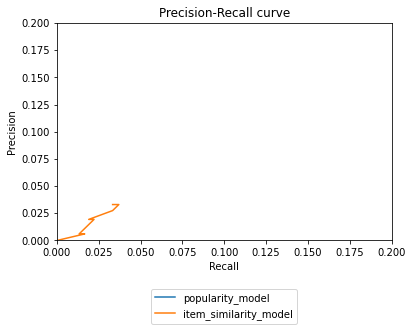

In [64]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

Plotting precision recall curves.


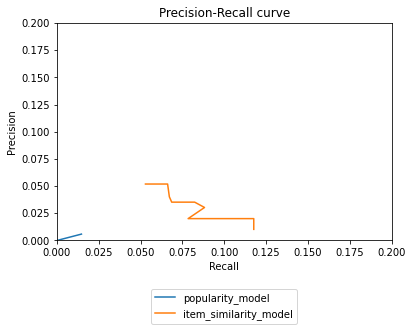

In [65]:
#Generating precision and recall on a larger subset of data
#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


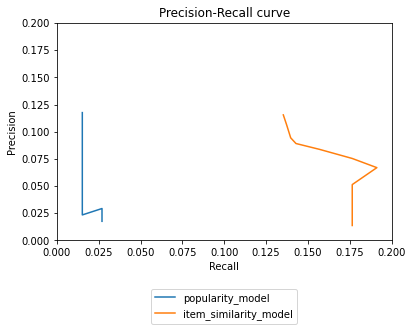

In [66]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

pm_avg_precision_list = joblib.load('pm_avg_precision_list_2.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_2.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_2.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_2.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

In [67]:
#Popularity model simply recommends top 10 songs to every user based on
#listen_count whereas the is_model gives personalilzed recommendation to
#every user and hence, we can see in the above graphs that it's performance
#is better than the popularity model